# Housing Insecurity Project: Predicting Areas with High Eviction Rates

Written by Laura Prichard, 30 October 2021

**Objectives**

- Use data on housing loss to find factors that can reduce housing insecurity. 
- Predict areas with above average eviction rates based on correlating demographic factors.
- Model can be used to easily identify areas that may have higher than average eviction rates so additional resources can be allocated to reduce housing loss.

**Data Used**

- From the [DataKind Data Dive](https://datadive.datakind.org/), Housing Insecurity Project, 18 September 2021
- [**Housing Insecurity Project**](https://docs.google.com/document/d/1ovSvMK39wO6NXqCrH0chQL7aRHR6Lr0vQIzXhmUEBFk/edit) | [Project GitHub](https://github.com/datakind/sep21-housing-insecurity) | [Tasks](https://docs.google.com/spreadsheets/d/1H4KZ31jKkhyBYXAlYm_Bw-RjTNkVoeskye0GwtbPuvM/edit?pli=1#gid=0) | [Data Folder](https://drive.google.com/drive/folders/19B0xzeRyozYJDxwXKlGIPFe3Qnc3nfux)
- Previously performed Exploratory Data Analysis on the National Housing Preservation Database (NHPD)
- Some data cleaning to homogenize column formats and variables, already complete. Code from others to combine data from different sources. Combined in [HousingInsecurity_RentPredictionModel.ipynb](https://github.com/lprichard/machine_learning/blob/main/HousingInsecurity_RentPredictionModel.ipynb).

**Skills**
- Data Cleaning
- Exploratory Data Analysis
- Feature Engineering
- Testing of Feature Importance
- Predictive Modeling
- Hyperparameter Tuning
- Training & Testing Models
    - Linear Regression
    - Logistic Regression
    - K-Nearest Neigbors
    - Decision Tree
- Cross Validation

**Overview**

This investigation aimed to predict areas with higher than average eviction rates in social housing based on demographic information of the areas. The primary objective was to test and generate a model of prediction that could be used to identify areas where the eviction rate has historically been shown to be higher than average so that additional policy and resources can be put in place to prevent housing loss.

Starting from a combination of large data sets, the NHPD and ACS, the data were combined, aggregated by census tract data and cleaned ready for analysis. Using data exploration, the most useful and important features were selected (`pct-white`, `pct-af-am`, `english-fluency`, `pct-without-health-insurance`) for predicting the target variable (`avg-eviction-rate`). The target variable was transformed to a binary value of above average eviction rates (`abv-avg-eviction-rate`) to be used for classification.

Three classifier models were trained and tested:
- MODEL 1: Logistic Regression
- MODEL 2: K-Nearest Neighbors
- MODEL 3: Decision Tree

Model 3 returned the highest accuracy score of 0.81 and was deemed the best fitting model and easy to interpret and apply to the data for other users. The different leaves nodes hold useful information that may be used to identify key characteristics of neighborhoods with higher than average eviction rates.

Many features in the database have no correlation to the average eviction rate. Work was done to identify the best features for prediction, some of which are strongly correlated to each other, and each of the four used show a correlation with the target variable. These features are likely to have root underlying causes. Ultimately areas with these key demographic trends should be targeted for the most housing assistance to prevent evictions.

**Conclusions**

**Recommending MODEL 3: Decision Tree** for predicting higher than average eviction rates from four key demographic properties of areas. 

**Next Steps**

- Accuracy score of 0.81 is reasonable given the stochastic nature of the real-world data. Perhaps there are features not included in the database that could have better correlation with the target variable, such as poverty rates. 
- This analysis is based on only three counties worth of data in Florida. Expanding this analysis to more counties would be interesting to see how the relation between these predictive metrics and the target variables varies by area across the US.

In [1]:
import os
import copy
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, r2_score, f1_score, precision_score, recall_score

pd.options.display.max_rows = 100

# Load data

In [2]:
# Set data directory
data_root = "/Users/lprichard/Dropbox/Data_Science/DataKind_18Sep21/"
os.chdir(data_root)

# Load in data
df = pd.read_csv('./data/nhpd_loss_censustract_clean_florida.csv')
display(df.head())
display(df.info())
df.columns.to_list()

,CensusTract,County,CountyCode,ActiveSubsidies,TotalInconclusiveSubsidies,TotalInactiveSubsidies,TotalUnits,NumberActiveSection8,NumberInconclusiveSection8,NumberInactiveSection8,...,avg-foreclosure-rate,foreclosure-rate-2017,foreclosure-rate-2018,foreclosure-rate-2019,avg-eviction-rate,ratio-to-mean-foreclosure-rate,ratio-to-mean-eviction-rate,avg-housing-loss-rate,evictions-pct-total-housing-loss,housing-loss-index
0,1.205700e+10,Hillsborough,12057.0,8,0,1,55.0,4,0,0,...,0.925926,1.923077,0.213675,0.641026,2.860353,1.311987,1.262704,2.448286,0.919438,1.613917
1,1.205700e+10,Hillsborough,12057.0,4,0,3,85.0,2,0,0,...,1.374570,1.030928,1.030928,2.061856,3.600563,1.947692,1.589470,3.444325,0.971989,2.270508
2,1.205700e+10,Hillsborough,12057.0,1,0,0,84.0,0,0,0,...,1.400000,1.800000,1.800000,0.600000,4.615454,1.983724,2.037495,3.711221,0.893916,2.446447
3,1.205700e+10,Hillsborough,12057.0,1,0,0,2.0,0,0,0,...,2.020202,2.020202,1.851852,2.188552,3.730073,2.862517,1.646643,3.314329,0.851795,2.184815
4,1.205700e+10,Hillsborough,12057.0,1,0,0,96.0,0,0,0,...,1.149425,1.149425,1.149425,1.149425,5.487367,1.628673,2.422401,3.914863,0.893568,2.580689


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 90 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   CensusTract                               326 non-null    float64
 1   County                                    326 non-null    object 
 2   CountyCode                                326 non-null    float64
 3   ActiveSubsidies                           326 non-null    int64  
 4   TotalInconclusiveSubsidies                326 non-null    int64  
 5   TotalInactiveSubsidies                    326 non-null    int64  
 6   TotalUnits                                326 non-null    float64
 7   NumberActiveSection8                      326 non-null    int64  
 8   NumberInconclusiveSection8                326 non-null    int64  
 9   NumberInactiveSection8                    326 non-null    int64  
 10  NumberActiveSection202                

None

['CensusTract',
 'County',
 'CountyCode',
 'ActiveSubsidies',
 'TotalInconclusiveSubsidies',
 'TotalInactiveSubsidies',
 'TotalUnits',
 'NumberActiveSection8',
 'NumberInconclusiveSection8',
 'NumberInactiveSection8',
 'NumberActiveSection202',
 'NumberActiveHUDInsured',
 'NumberInconclusiveHUDInsured',
 'NumberInactiveHud',
 'NumberActiveLihtc',
 'NumberInconclusiveLihtc',
 'NumberInactiveLihtc',
 'NumberActiveSection515',
 'NumberInactiveSection515',
 'NumberActiveSection538',
 'NumberActiveHome',
 'NumberInconclusiveHome',
 'NumberInactiveHome',
 'NumberActivePublicHousing',
 'NumberInactivePublicHousing',
 'NumberActiveState',
 'NumberInactiveState',
 'NumberActivePBV',
 'NumberActiveMR',
 'FairMarketRent_2BR',
 'total-households',
 'total-renter-occupied-households',
 'total-owner-occupied-households',
 'total-owner-occupied-households-mortgage',
 'median-gross-rent',
 'median-household-income',
 'median-property-value',
 'median-monthly-housing-cost',
 'pct-white',
 'pct-af-am',


# Exploratory data analysis, testing feature importance

In [3]:
# Getting numeric columns
data = copy.deepcopy(df)
mask1 = data.dtypes == np.float
mask2 = data.dtypes == np.int
mask = mask1 | mask2
num_cols = data.columns[mask]

In [4]:
# Check null entries
data[num_cols].info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 89 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   CensusTract                               326 non-null    float64
 1   CountyCode                                326 non-null    float64
 2   ActiveSubsidies                           326 non-null    int64  
 3   TotalInconclusiveSubsidies                326 non-null    int64  
 4   TotalInactiveSubsidies                    326 non-null    int64  
 5   TotalUnits                                326 non-null    float64
 6   NumberActiveSection8                      326 non-null    int64  
 7   NumberInconclusiveSection8                326 non-null    int64  
 8   NumberInactiveSection8                    326 non-null    int64  
 9   NumberActiveSection202                    326 non-null    int64  
 10  NumberActiveHUDInsured                

In [5]:
# Remove non ID numeric columns
rem_cols = ['CensusTract', 'CountyCode'] 
an_cols = num_cols.drop(rem_cols)

# Print number of columns & names
print(len(an_cols))
an_cols

87


Index(['ActiveSubsidies', 'TotalInconclusiveSubsidies',
       'TotalInactiveSubsidies', 'TotalUnits', 'NumberActiveSection8',
       'NumberInconclusiveSection8', 'NumberInactiveSection8',
       'NumberActiveSection202', 'NumberActiveHUDInsured',
       'NumberInconclusiveHUDInsured', 'NumberInactiveHud',
       'NumberActiveLihtc', 'NumberInconclusiveLihtc', 'NumberInactiveLihtc',
       'NumberActiveSection515', 'NumberInactiveSection515',
       'NumberActiveSection538', 'NumberActiveHome', 'NumberInconclusiveHome',
       'NumberInactiveHome', 'NumberActivePublicHousing',
       'NumberInactivePublicHousing', 'NumberActiveState',
       'NumberInactiveState', 'NumberActivePBV', 'NumberActiveMR',
       'FairMarketRent_2BR', 'total-households',
       'total-renter-occupied-households', 'total-owner-occupied-households',
       'total-owner-occupied-households-mortgage', 'median-gross-rent',
       'median-household-income', 'median-property-value',
       'median-monthly-housing-

In [6]:
# Calculate the correlation values
feature_cols = an_cols[:-1]
corr_values = data[feature_cols].corr()
corr_values

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

In [7]:
# Get most correlated features
feat1 = corr_values.sort_values('abs_correlation', ascending=False)[:400].feature1.unique()
feat2 = corr_values.sort_values('abs_correlation', ascending=False)[:400].feature2.unique()
feats = np.concatenate((feat1, feat2))
list(np.unique(feats))

['ActiveSubsidies',
 'FairMarketRent_2BR',
 'NumberActiveHUDInsured',
 'NumberActiveHome',
 'NumberActiveLihtc',
 'NumberActivePublicHousing',
 'NumberActiveSection515',
 'NumberActiveSection8',
 'NumberActiveState',
 'NumberInactiveHud',
 'NumberInactiveLihtc',
 'NumberInactivePublicHousing',
 'NumberInactiveSection515',
 'NumberInconclusiveHUDInsured',
 'NumberInconclusiveLihtc',
 'NumberInconclusiveSection8',
 'TotalInactiveSubsidies',
 'TotalInconclusiveSubsidies',
 'avg-eviction-rate',
 'avg-evictions',
 'avg-foreclosure-rate',
 'avg-foreclosure-sales',
 'avg-housing-loss-rate',
 'drive-to-work',
 'english-fluency',
 'eviction-filings-2017',
 'eviction-filings-2018',
 'eviction-filings-2019',
 'eviction-rate-2017',
 'eviction-rate-2018',
 'evictions-pct-total-housing-loss',
 'foreclosure-rate-2017',
 'foreclosure-rate-2018',
 'foreclosure-rate-2019',
 'foreclosure-sales-2017',
 'foreclosure-sales-2018',
 'foreclosure-sales-2019',
 'households-children',
 'immigrant-status',
 'leve

In [8]:
# Test cols to select the best for analysis
tcols = ['ActiveSubsidies',
         'FairMarketRent_2BR',
#          'NumberActiveHUDInsured',
#          'NumberActiveHome',
#          'NumberActiveLihtc',
#          'NumberActivePublicHousing',
#          'NumberActiveSection515',
#          'NumberActiveSection8',
#          'NumberActiveState',
#          'NumberInactiveHud',
#          'NumberInactiveLihtc',
#          'NumberInactivePublicHousing',
#          'NumberInactiveSection515',
#          'NumberInconclusiveHUDInsured',
#          'NumberInconclusiveLihtc',
#          'NumberInconclusiveSection8',
         'TotalInactiveSubsidies',
#          'TotalInconclusiveSubsidies',
         'avg-eviction-rate',
         'avg-evictions',
         'avg-foreclosure-rate',
         'avg-foreclosure-sales',
         'avg-housing-loss-rate',
         'drive-to-work',
         'english-fluency',
#          'eviction-filings-2017',
#          'eviction-filings-2018',
#          'eviction-filings-2019',
#          'eviction-rate-2017',
#          'eviction-rate-2018',
         'evictions-pct-total-housing-loss',
#          'foreclosure-rate-2017',
#          'foreclosure-rate-2018',
#          'foreclosure-rate-2019',
#          'foreclosure-sales-2017',
#          'foreclosure-sales-2018',
#          'foreclosure-sales-2019',
         'households-children',
         'immigrant-status',
         'level-of-education',
         'median-gross-rent',
         'median-house-age',
         'median-household-income',
         'median-monthly-housing-cost',
         'median-property-value',
         'older-adult-alone',
#          'pct-af-am',
#          'pct-asian',
#          'pct-hispanic',
#          'pct-multiple',
         'pct-non-white',
         'pct-other',
         'pct-owner-occupied',
#          'pct-owner-occupied-mortgage',
#          'pct-owner-occupied-without-mortgage',
         'pct-renter-occupied',
         'pct-white',
         'pct-without-health-insurance',
         'public-transport-to-work',
         'ratio-to-mean-eviction-rate',
         'ratio-to-mean-foreclosure-rate',
         'single-parent-household',
         'total-evictions',
#          'total-evictions-2017',
#          'total-evictions-2018',
#          'total-evictions-2019',
         'total-foreclosure-sales',
         'total-households',
         'total-owner-occupied-households',
         'total-owner-occupied-households-mortgage',
         'total-renter-occupied-households',
         'vacant-properties']

data[tcols]

,ActiveSubsidies,FairMarketRent_2BR,TotalInactiveSubsidies,avg-eviction-rate,avg-evictions,avg-foreclosure-rate,avg-foreclosure-sales,avg-housing-loss-rate,drive-to-work,english-fluency,...,ratio-to-mean-eviction-rate,ratio-to-mean-foreclosure-rate,single-parent-household,total-evictions,total-foreclosure-sales,total-households,total-owner-occupied-households,total-owner-occupied-households-mortgage,total-renter-occupied-households,vacant-properties
0,8,1220.0,1,2.860353,49.455508,0.925926,4.333333,2.448286,1939,3790,...,1.262704,1.311987,56,148.366525,13.0,2484,755,468,1729,111
1,4,1070.0,3,3.600563,46.267235,1.374570,1.333333,3.444325,958,2610,...,1.589470,1.947692,70,138.801706,4.0,1448,163,97,1285,236
2,1,1070.0,0,4.615454,58.985507,1.400000,7.000000,3.711221,1760,3718,...,2.037495,1.983724,36,176.956522,21.0,1954,676,500,1278,160
3,1,1070.0,0,3.730073,68.969051,2.020202,12.000000,3.314329,1874,4334,...,1.646643,2.862517,112,206.907154,36.0,2748,899,594,1849,115
4,1,1220.0,0,5.487367,33.582687,1.149425,4.000000,3.914863,1002,1704,...,2.422401,1.628673,30,100.748062,12.0,1069,457,348,612,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,1,1980.0,0,2.512877,71.315436,0.509075,7.666667,1.818188,4965,7534,...,0.792977,0.362263,237,213.946309,23.0,5009,2171,1506,2838,995
322,2,1130.0,2,15.287067,70.931990,2.640264,8.000000,10.291003,974,1584,...,4.824070,1.878842,106,212.795970,24.0,906,442,303,464,262
323,1,1500.0,0,1.031488,6.333333,0.986193,3.333333,1.015406,890,1869,...,0.325502,0.701787,55,19.000000,10.0,1097,483,338,614,73
324,11,1160.0,2,2.463824,28.087591,3.490401,13.333333,2.721480,1062,4093,...,0.777498,2.483810,112,84.262774,40.0,1810,670,382,1140,254


In [9]:
# Now testing which features correlate most with the target: avg-eviction-rate
y = data['avg-eviction-rate']
correlations = data[an_cols].corrwith(y)
correlations.sort_values(inplace=True)
correlations

pct-hispanic                               -0.331555
pct-white                                  -0.328702
immigrant-status                           -0.321522
FairMarketRent_2BR                         -0.304123
median-property-value                      -0.298233
median-monthly-housing-cost                -0.283195
median-gross-rent                          -0.219889
median-household-income                    -0.178935
older-adult-alone                          -0.145692
single-parent-household                    -0.115434
NumberActiveSection8                       -0.112457
households-children                        -0.092738
NumberActiveSection515                     -0.092702
drive-to-work                              -0.089056
total-owner-occupied-households            -0.088261
total-households                           -0.084459
NumberInactiveSection8                     -0.082421
NumberActiveHome                           -0.079811
total-owner-occupied-households-mortgage   -0.

In [10]:
# Downselect and test feature importance
# icols = ['pct-hispanic', 'pct-white', 'pct-af-am',  'english-fluency', 'public-transport-to-work',
#          'pct-without-health-insurance', 'live-in-mobile-home', 'TotalUnits', 'NumberActiveSection8', 'households-children',
#          'immigrant-status', 'FairMarketRent_2BR', 'median-property-value', 'median-monthly-housing-cost',
#          'median-gross-rent', 'median-household-income', 'older-adult-alone', 'single-parent-household',
#          'avg-eviction-rate']
icols = ['pct-white', 'pct-af-am',  'english-fluency', 'pct-without-health-insurance', 'avg-eviction-rate']

In [11]:
data[icols].describe()

,pct-white,pct-af-am,english-fluency,pct-without-health-insurance,avg-eviction-rate
count,326.000000,326.000000,326.000000,326.000000,326.000000
mean,1287.226994,513.742331,2502.113497,18.245616,2.420351
std,891.556784,504.462134,1858.271899,7.369342,1.888502
min,33.000000,0.000000,52.000000,1.608257,0.114811
25%,641.000000,115.250000,1202.250000,12.712377,1.217777
50%,1153.500000,335.500000,2229.500000,17.603093,1.963240
75%,1692.000000,791.500000,3450.000000,22.696596,3.036038
max,8072.000000,2565.000000,16487.000000,42.629482,15.287067


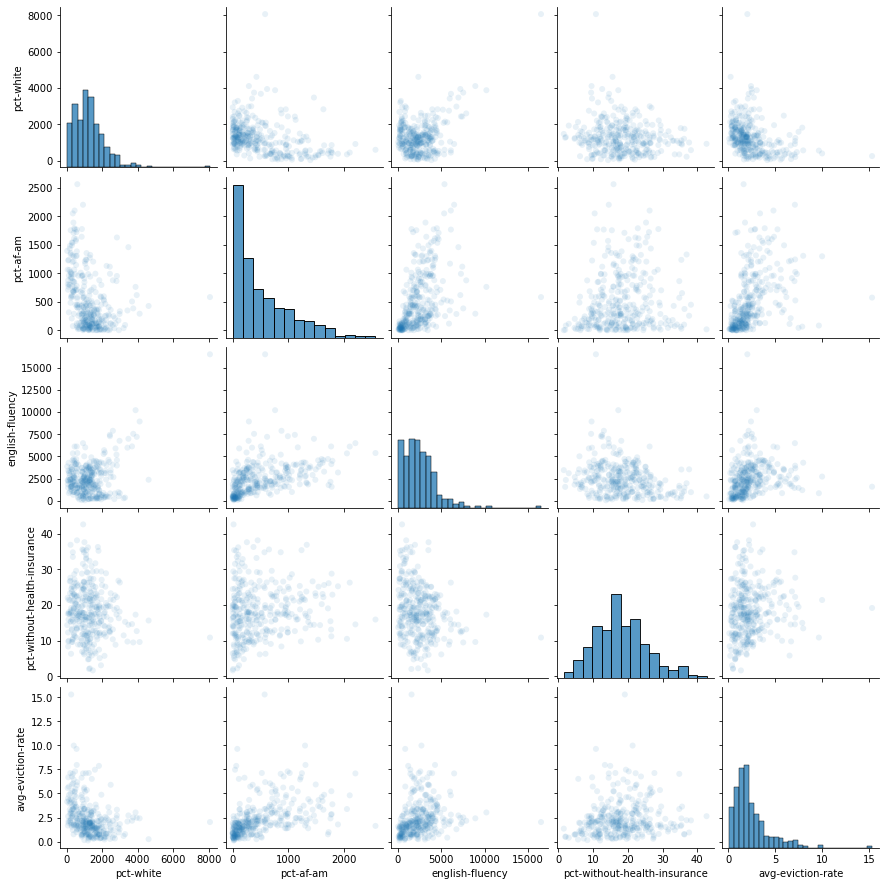

In [12]:
# Compare feature relations
sns.pairplot(data[icols], plot_kws=dict(alpha=.1, edgecolor='none'))

# Testing Linear Regression

In [13]:
# Define model
lr = LinearRegression()

In [14]:
# Define data sets
y_col = "avg-eviction-rate"

X = data[icols].drop(y_col, axis=1)
y = data[y_col]

In [15]:
# Split data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72018)

In [16]:
# Scale the training data
s = StandardScaler()
X_train_s = s.fit_transform(X_train)

In [17]:
# Do a boxcox tranformation on the y data
bc_result1 = boxcox(y_train)
y_train_bc = bc_result1[0]
lam1 = bc_result1[1]
lam1

0.19611718864215705

In [18]:
# Run linear regression on transformed data
lr.fit(X_train_s, y_train_bc)
X_test_s = s.transform(X_test)
y_pred_bc = lr.predict(X_test_s)

In [19]:
# Determine R2 score
y_pred_tran = inv_boxcox(y_pred_bc,lam1)
r2_score(y_pred_tran,y_test)

-0.32803848779431877

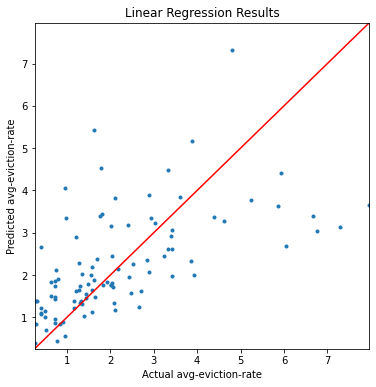

In [20]:
# Compare actual vs predicted values
f = plt.figure(figsize=(6,6))
ax = plt.axes()

# Plot the test data and predictions
ax.plot(y_test, y_pred_tran, 
         marker='o', ls='', ms=3.0)

xvals = np.linspace(y_test.min(), y_test.max(),100)
plt.plot(xvals, xvals, '-r')

lim = (y_test.min(), y_test.max())

ax.set(xlabel='Actual avg-eviction-rate', 
       ylabel='Predicted avg-eviction-rate', 
       xlim=lim,
       ylim=lim,
       title='Linear Regression Results');

# Define Target Variable

In [21]:
# Compare averages
print(data['avg-eviction-rate'].mean())
print(data['avg-eviction-rate'].median())

2.4203506536320845
1.9632404586275243


In [22]:
# Define new target variable 
data['abv-avg-eviction-rate'] = (data['avg-eviction-rate'] >= data['avg-eviction-rate'].median()).astype(np.int)

In [23]:
# Get columns for analysis
cols = icols + ['abv-avg-eviction-rate']
data[cols]

,pct-white,pct-af-am,english-fluency,pct-without-health-insurance,avg-eviction-rate,abv-avg-eviction-rate
0,1217,986,3790,12.285892,2.860353,1
1,432,846,2610,24.672489,3.600563,1
2,847,953,3718,19.553259,4.615454,1
3,1307,1274,4334,21.705804,3.730073,1
4,499,447,1704,20.594480,5.487367,1
...,...,...,...,...,...,...
321,3751,383,7534,9.463956,2.512877,1
322,257,573,1584,19.147046,15.287067,1
323,1024,54,1869,11.671803,1.031488,0
324,532,1146,4093,15.870656,2.463824,1


# Train & Test Classifiers

In [24]:
# Define columns
ycol = 'abv-avg-eviction-rate'
feature_cols = data[cols].columns[:-2]   # Remove both eviction rate variables from features

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data[ycol]))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, ycol]

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, ycol]

# **Logistic Regression**

In [25]:
# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [26]:
# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [27]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)

In [28]:
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,0,0,0


In [29]:
y_prob.head()

,lr,l1,l2
0,0.890130,0.886541,0.886883
1,0.941197,0.961178,0.959180
2,0.836448,0.841702,0.840991
3,0.731527,0.732859,0.732751
4,0.806389,0.808282,0.808182


In [30]:
# Get metrics for each of the logistic regression models
metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # Define confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

In [31]:
metrics

,lr,l1,l2
precision,0.777358,0.786789,0.786789
recall,0.775510,0.785714,0.785714
fscore,0.775136,0.785513,0.785513
accuracy,0.775510,0.785714,0.785714


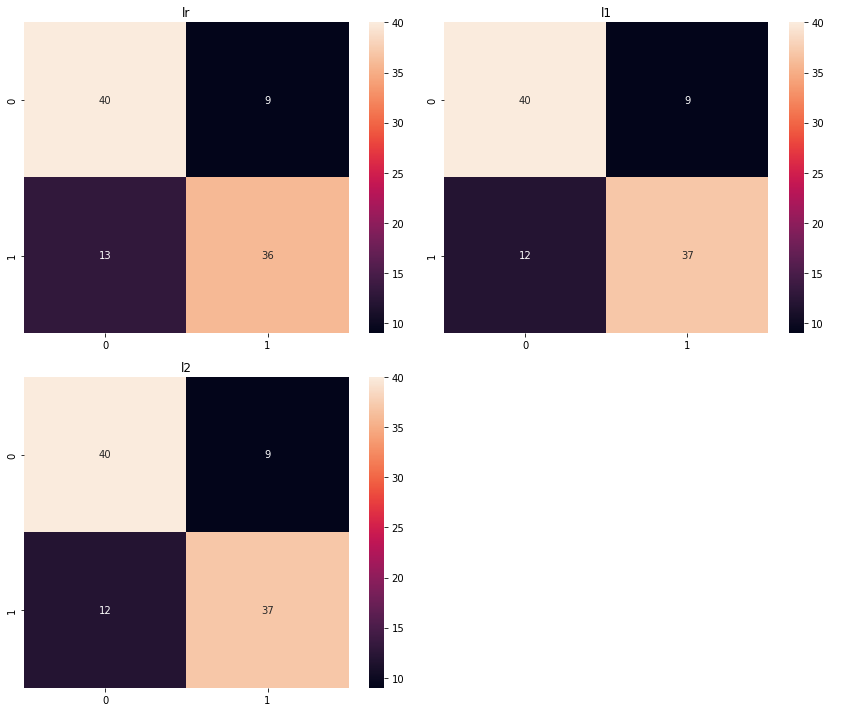

In [32]:
# Plot confusion matrices
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()

# **K-Nearest Neighbors**

In [33]:
# Test values for K
max_k = 40
f1_scores = list()
error_rates = list()

for k in range(1, max_k):
    
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn = knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    f1 = f1_score(y_pred, y_test)
    f1_scores.append((k, round(f1_score(y_test, y_pred), 4)))
    error = 1-round(accuracy_score(y_test, y_pred), 4)
    error_rates.append((k, error))
    
f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score'])
error_results = pd.DataFrame(error_rates, columns=['K', 'Error Rate'])

<Figure size 1800x1200 with 0 Axes>

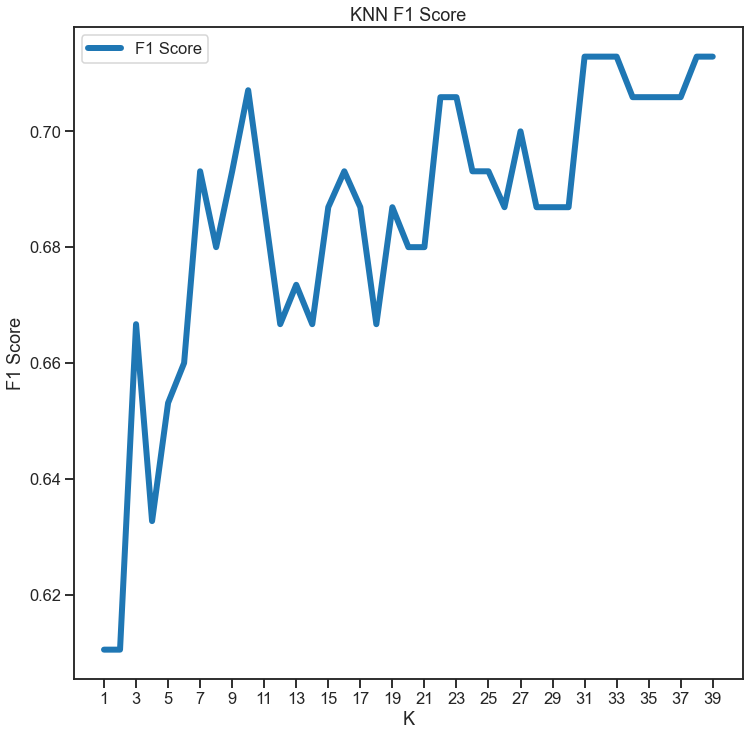

In [34]:
# Plot F1 results
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = f1_results.set_index('K').plot(figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='F1 Score')
ax.set_xticks(range(1, max_k, 2));
plt.title('KNN F1 Score')
plt.savefig('knn_f1.png')

Text(0.5, 1.0, 'KNN Elbow Curve')

<Figure size 1800x1200 with 0 Axes>

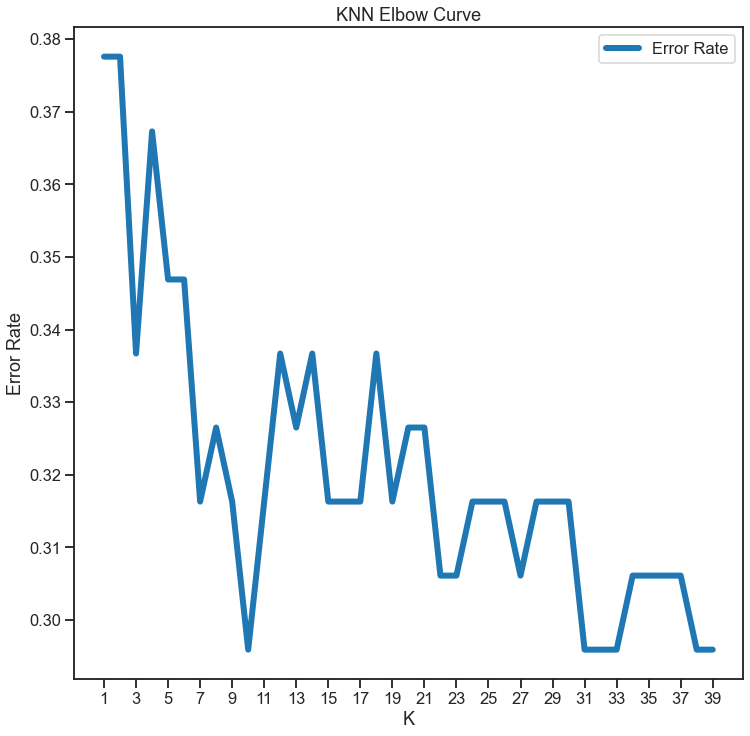

In [35]:
# Plot accuracy results
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = error_results.set_index('K').plot(figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='Error Rate')
ax.set_xticks(range(1, max_k, 2))
plt.title('KNN Elbow Curve')

In [36]:
# Estimate KNN model and report outcomes
knn = KNeighborsClassifier(n_neighbors=9)
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Precision, recall, f-score
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred), 2))

              precision    recall  f1-score   support

           0       0.74      0.69      0.72        49
           1       0.71      0.76      0.73        49

    accuracy                           0.72        98
   macro avg       0.73      0.72      0.72        98
weighted avg       0.73      0.72      0.72        98

Accuracy score:  0.72
F1 Score:  0.73


Text(0.5, 76.5, 'Ground Truth')

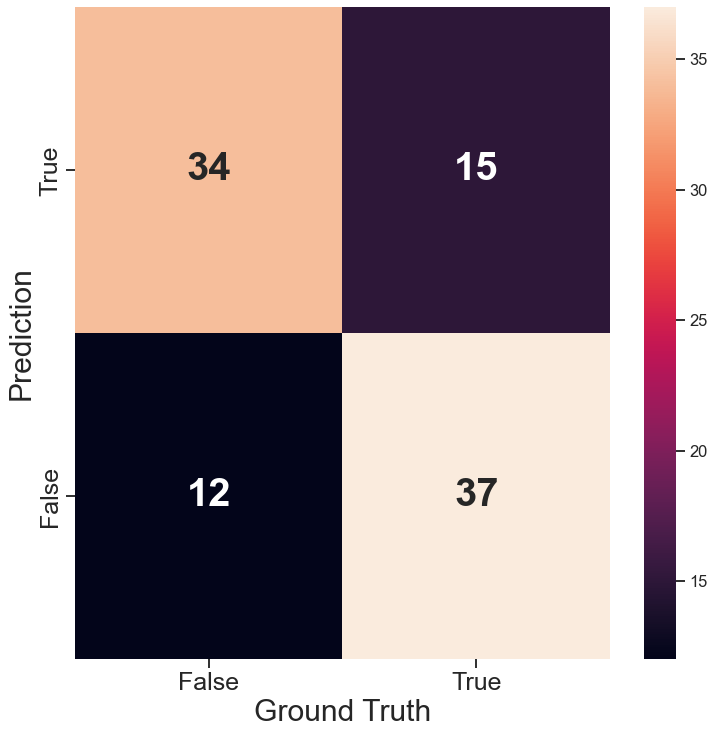

In [37]:
# Plot confusion matrix
_, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"})  
labels = ['False', 'True']
ax.set_xticklabels(labels, fontsize=25);
ax.set_yticklabels(labels[::-1], fontsize=25);
ax.set_ylabel('Prediction', fontsize=30);
ax.set_xlabel('Ground Truth', fontsize=30)

In [38]:
# Test adding weights to KNN model
knn = KNeighborsClassifier(n_neighbors=9, weights='distance')
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Precision, recall, f-score
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred), 2))

              precision    recall  f1-score   support

           0       0.70      0.65      0.67        49
           1       0.67      0.71      0.69        49

    accuracy                           0.68        98
   macro avg       0.68      0.68      0.68        98
weighted avg       0.68      0.68      0.68        98

Accuracy score:  0.68
F1 Score:  0.69


# **Decision Tree**

In [39]:
# Define and train decision basic decision tree
dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)

In [40]:
# Get maximum values
dt.tree_.node_count, dt.tree_.max_depth

(99, 14)

In [41]:
def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred)},
                      name=label)

In [42]:
# Get errors from the train and test sets
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

train_test_full_error = pd.concat([measure_error(y_train, y_train_pred, 'train'),
                              measure_error(y_test, y_test_pred, 'test')],
                              axis=1)

train_test_full_error

,train,test
accuracy,1.0,0.673469
precision,1.0,0.742857
recall,1.0,0.530612
f1,1.0,0.619048


In [43]:
# Use cross-validation for hyperparameter tuning
param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, len(dt.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

GR = GR.fit(X_train, y_train)

In [44]:
# Get best values 
GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth

(15, 3)

In [45]:
# Re run model with best values
y_train_pred_gr = GR.predict(X_train)
y_test_pred_gr = GR.predict(X_test)

train_test_gr_error = pd.concat([measure_error(y_train, y_train_pred_gr, 'train'),
                                 measure_error(y_test, y_test_pred_gr, 'test')],
                                axis=1)

In [46]:
train_test_gr_error

,train,test
accuracy,0.789474,0.806122
precision,0.735714,0.767857
recall,0.903509,0.877551
f1,0.811024,0.819048


In [47]:
# Print tree 
text_representation = tree.export_text(dt)
print(text_representation)

|--- feature_1 <= 209.50
|   |--- feature_0 <= 934.50
|   |   |--- feature_2 <= 1618.50
|   |   |   |--- feature_2 <= 998.00
|   |   |   |   |--- feature_0 <= 655.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_0 >  655.00
|   |   |   |   |   |--- feature_0 <= 928.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_0 >  928.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- feature_2 >  998.00
|   |   |   |   |--- class: 0
|   |   |--- feature_2 >  1618.50
|   |   |   |--- class: 1
|   |--- feature_0 >  934.50
|   |   |--- feature_2 <= 1183.00
|   |   |   |--- class: 0
|   |   |--- feature_2 >  1183.00
|   |   |   |--- feature_2 <= 1302.50
|   |   |   |   |--- feature_1 <= 31.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_1 >  31.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- feature_2 >  1302.50
|   |   |   |   |--- feature_1 <= 111.50
|   |   |   |   |   |--- feature_1 <= 66.00
|   |   |   |   |   |   |--- class